# Bayesian Convolutional Network

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [2]:
# load commons and models module
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
import models 
importlib.reload(cm)
importlib.reload(models)

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0
Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


<module 'models' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\bayesian_nlp\\models.py'>

# Configuration, Parameters and Setup

In [3]:
# Only needs to be run once per enviroment. Downloads requiered wordnet package for nltk 
cm.one_time_setup()

# Also make sure to have access to the pretrained GloVe embedding model.
# We use glove.6B.zip from https://nlp.stanford.edu/projects/glove/

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Directory containing the GloVe files.
glove_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/glove"

# Directory containing the trained model
models_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/models"

# Directory containing the training history
history_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/history"

# Embedding dimension (all models are pretrained for dimension 50)
embedding_dim = 50

# Fraction of the dataset to be used as training_data
dataset_sizes=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.005]
trainingset_proportion = dataset_sizes[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 50

In [4]:
setup = cm.setup(glove_dir=glove_dir,
                 embedding_dim=embedding_dim,
                 trainingset_proportion=trainingset_proportion)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

# number of data points
N = x_train.shape[0]

Found 400000 word vectors.
17361/88587 unknown words


# Model

In [5]:
bayesian_conv_model = models.BayesianConvModel(model_setup=setup,
                                                      models_dir=models_dir,
                                                      history_dir=history_dir)

In [6]:
bayesian_conv_model.keras_summary()

Model: "bayesian_conv_reparameterization_24909"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          4429400   
_________________________________________________________________
conv1d_reparameterization (C (None, 1000, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 333, 128)          0         
_________________________________________________________________
conv1d_reparameterization_1  (None, 333, 64)           49216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 111, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7104)              0         
_________________________________________________________________
dense_reparameterization (De

In [10]:
bayesian_conv_model.fit(epochs=epochs, batch_size=batch_size)

using saved model
Loaded history successfully. Last epoch: 50


W0628 17:41:56.015898 10152 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23750 samples, validate on 1250 samples


# History

In [7]:
(history_df, last_epoch) = bayesian_conv_model.load_history()

Loaded history successfully. Last epoch: 50


# Tests

In [8]:
model = bayesian_conv_model.load_model()
loss, accuracy, *other = model.evaluate(x_test_padded, y_test)
print("Test loss: %.2f\nTest accuracy: %.2f%%" % (loss, accuracy * 100))

using saved model
22419/22419 [==============================] - 15s 653us/sample - loss: 2.2629 - acc: 0.8086 - true_negatives: 9723.0000 - false_negatives: 2836.0000 - true_positives: 8405.0000 - false_positives: 1455.0000 - precision: 0.8524 - recall: 0.7477 - kl: 0.2715
Test loss: 2.26
Test accuracy: 80.86%


using saved model


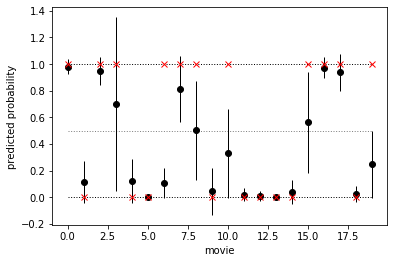

74
128
81
208
396
114
780
151
282
255
316
61
402
50
718
351
67
167
301
358


In [29]:
model = bayesian_conv_model.load_model()
n = 20
samples = 100

y_pred = [model.predict(x_test_padded[:n]) for i in range(samples)]
y_pred = np.array(y_pred)

means = [np.mean(y_pred[:, i]) for i in range(n)]
stddevs = [np.std(y_pred[:, i]) for i in range(n)]
cm.plot_confidence(means, stddevs, y_test[:n])
[print(len(seq)) for seq in x_test[:n]]
None

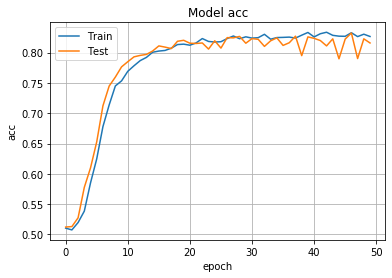

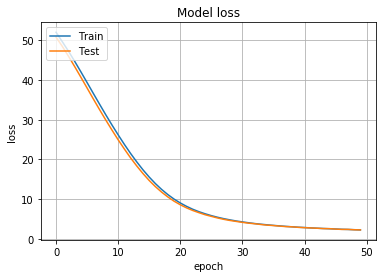

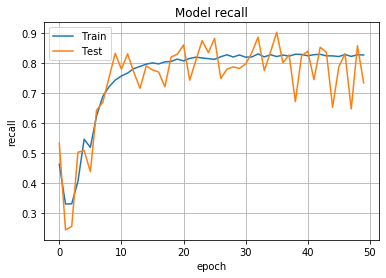

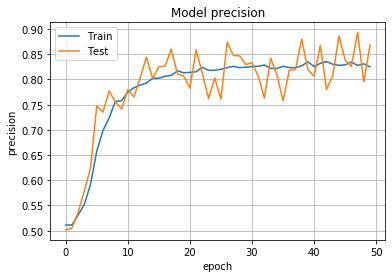

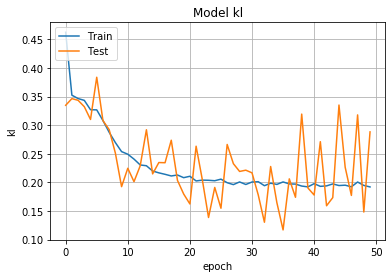

In [10]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()